# Projection of political actors onto a scale of pro- vs anti-EU

In [1]:
# Make sure politician2vec is up to date
#%pip uninstall politician2vec -y
#%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

# Make sure to auto-reload politician2vec in case there are remote changes
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
# import multiprocessing
# available_workers = multiprocessing.cpu_count()
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Specify path to preprocessed dataset
test_data_path = 'data/clean/preprocessed_docs.p'

parl_data = pd.read_pickle(test_data_path).query("party not in ['SIU', 'NQ', 'JF', 'SP']")
parl_data.shape

(91839, 6)

In [4]:
grouped_docs = parl_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])


In [5]:
# Load embedding
model_path = 'embedding_models/fastlearn_v1.txt'
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [6]:
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'Enhedslisten',
   4: 'Radikale Venstre',
   5: 'SF',
   6: 'Konservative',
   7: 'Liberal_Alliance',
   8: 'UFG',
   9: 'Alternativet',
   10: 'Danmarksdemokraterne',
   11: 'Nye Borgerlige',
   12: 'Frie Grønne',
   13: 'Moderaterne',
   14: 'Kristendemokraterne'
}

In [7]:
colormap = { # TODO: COLLECT EVERYTHING IN ONE DICT/FRAME!!!!!
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [8]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 19,
    snippets = True
)

party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

party_df['rank'] = party_df['party'].map(party_df['party'].value_counts())

party_labels = party_df.drop_duplicates(keep = 'first', subset = 'party').sort_values(by='rank', ascending=False)

partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

party_labels

party sizes before filtering (party 19 is "Other"):

[[ 0 48]
 [ 1 44]
 [ 2 36]
 [ 3 16]
 [ 4 15]
 [ 5 15]
 [ 6 14]
 [ 7 13]
 [ 8 11]
 [ 9 11]
 [10  5]
 [11  4]
 [12  3]
 [13  1]
 [14  1]]


,doc,party,snippet,color,full_name,rank
2,2,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,51
6,6,V,tak for ordet nu har vi jo talt rigtig meget o...,#1A4289,Anne Honoré Østergaard,43
0,0,DF,tak det åbne spørgsmål er jo hvad socialdemokr...,#265BA4,Alex Ahrendtsen,34
33,33,EL,så må vi hellere gøre det godt og grundigt sid...,#BF2850,Christian Juhl,16
4,4,RV,i radikale venstre forstår vi lovforslaget såd...,#D82E8A,Andreas Steenberg,15
9,9,SF,tak for det vi er flere her der har svære navn...,#B42D27,Anne Valentina Berthelsen,15
19,19,KF,tak for det tak for en fin ordførertale det da...,#24573E,Birgitte Bergman,14
1,1,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13
17,17,UFG,tak for det formand hvad er ministerens holdni...,lightgrey,Bent Bøgsted,11
29,29,ALT,tak for det i sin tale sagde ministeren at han...,#75FB4C,Carolina Magdalene Maier,11


In [9]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')
combined_hover

,doc,party,snippet,color,full_name,rank
0,0.0,DF,tak det åbne spørgsmål er jo hvad socialdemokr...,#265BA4,Alex Ahrendtsen,34.0
1,1.0,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13.0
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,51.0
3,3.0,LA,tak for det og tak for en saglig og konstrukti...,#E7B657,Anders Samuelsen,13.0
4,4.0,RV,i radikale venstre forstår vi lovforslaget såd...,#D82E8A,Andreas Steenberg,15.0
...,...,...,...,...,...,...
247,NaN,DD,NaN,black,NaN,NaN
248,NaN,NB,NaN,black,NaN,NaN
249,NaN,FG,NaN,black,NaN,NaN
250,NaN,KD,NaN,black,NaN,NaN


In [10]:
# Arithmetic mean of input vectors
def mean_vec(vecs):
    return np.mean(vecs, axis=0)

# manually implement cosine similarity between two vectors,
# since phrases are not added to the internal doc2vec model...
def calc_cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# get vectors for input word
def get_vec(word):
    idx = pol2vec_model.word_indexes[word]
    vec = pol2vec_model.word_vectors[idx]
    
    return vec

# Define function that takes two words (or n-grams),
# retrieves the corresponding vectors, and returns the cosine similarity
def get_cos_sim(input_words):
    idcs = [pol2vec_model.word_indexes[word] for word in input_words]
    vec1, vec2 = [pol2vec_model.word_vectors[idx] for idx in idcs]
    
    return calc_cos_sim(vec1, vec2)

In [11]:
from itertools import combinations
from tqdm.notebook import tqdm

class Subdimension:
    def __init__(self, present_words, absent_words):
        self.words = {'present': present_words, 'absent': absent_words}
        self.vecs = {'present': [get_vec(word) for word in present_words], 'absent': [get_vec(word) for word in absent_words]}
    
    def add_words(self, words, present = True):
        '''
        Manually add extra words and their vector representations to the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._add_word(word, present)
    
    def remove_words(self, words, present = True):
        '''
        Manually remove words and their vector representations from the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._remove_word(word, present)

    # Backend/helper functions below
    def _add_word(self, word, present = True): # TODO: Make it impossible to add the same word twice...
        self.words['present' if present else 'absent'].append(word)
        self.vecs['present' if present else 'absent'].append(self.get_vec(word))

    def _remove_word(self, word, present = True):
        remove_idx = self.words['present' if present else 'absent'].index(word)
        self.words['present' if present else 'absent'].remove(word)
        del self.vecs['present' if present else 'absent'][remove_idx]

    def calc_subdim_vecs(self):
        '''
        Return the arithmetic mean of both the "present" and the "absent"
        word sets (i.e. construct the endpoints of the subdimension).
        '''
        return mean_vec(self.vecs['present']), mean_vec(self.vecs['absent'])
    
    def optimise_subdim(self, present=True, min_size=2, max_size=None, replace=True):
        '''
        Optimise the subdimension by finding the word set that maximises the average cosine similarity

        Parameters
        ----------
        present : bool, optional
            Whether to optimise the "present" or "absent" endpoint of the subdimension, by default True
        min_size : int, optional
            Minimum number of words in the word set, by default 2
        max_size : int, optional
            Maximum number of words in the word set, by default None (i.e. no limit)
        replace : bool, optional
            Whether to replace the original word set with the optimised one, by default True

        Returns
        -------
        best_group : list
            The optimised word set.
        best_labels : list
            The corresponding word labels.
        best_sim : float
            The average cosine similarity of the optimal word set.
        '''
        
        best_group, best_labels, best_sim = self.optimise_group_similarity(
            vectors=self.vecs['present' if present else 'absent'],
            labels=self.words['present' if present else 'absent'],
            min_size=min_size,
            max_size=max_size
            )
        
        if replace:
            self.words['present' if present else 'absent'] = best_labels
            self.vecs['present' if present else 'absent'] = best_group
        
        print('Best avg. cosine similarity:', best_sim)
        
        return best_group, best_labels
    
    @staticmethod
    def get_vec(word):
        '''Retrieve the vector representation of a given word from the politician2vec model.'''
        idx = pol2vec_model.word_indexes[word]
        vec = pol2vec_model.word_vectors[idx]

        return vec
    
    @staticmethod
    def mean_vec(vecs):
        return np.mean(vecs, axis=1)

    @staticmethod
    def group_cosine_similarity(vectors):
        '''
        Calculates the average cosine similarity between all pairs of vectors in a group.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.

        Returns
        -------
        float: The average cosine similarity between all pairs of vectors in the group.
       '''

        # calculate the pairwise cosine similarities
        pairwise_sims = []
        for v1, v2 in combinations(vectors, 2):
            sim = calc_cos_sim(v1,v2)
            pairwise_sims.append(sim)

        # calculate the average cosine similarity
        avg_sim = np.mean(pairwise_sims)

        return avg_sim

    def optimise_group_similarity(self, vectors, labels, min_size, max_size):
        '''
        Optimizes the average cosine similarity of a group of vectors byiteratively removing and
        including different combinations.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.
        labels (list): A list of labels for the vectors.
        min_size (int): The minimum size of the group to consider. Default is 2.
        max_size (int): The maximum size of the group to consider. Default is None (use all vectors).

        Returns
        -------
        list: The optimized group of vectors that maximizes the average cosine similarity.
        list: The labels of the vectors in the optimized group.
        float: The maximum average cosine similarity achieved by the optimized group.
        '''

        # set max_size to len(vectors) if not specified
        if max_size is None:
            max_size = len(vectors)

        # initialize the best group, labels, and similarity
        best_group = None
        best_labels = None
        best_sim = 0.0

        # iterate over all possible group sizes
        for size in tqdm(range(min_size, max_size+1)):
            
            # iterate over all possible combinations of vectors
            for group_idx in combinations(range(len(vectors)), size):
                
                # get the vectors and labels for the current group
                group = [vectors[i] for i in group_idx]
                group_labels = [labels[i] for i in group_idx]
                
                # calculate the average cosine similarity of the group
                sim = self.group_cosine_similarity(group)
                
                # update the best group, labels, and similarity if a new maximum is found
                if sim > best_sim:
                    best_group = group
                    best_labels = group_labels
                    best_sim = sim

        return best_group, best_labels, round(best_sim, ndigits=3)


In [103]:
# TODO: FIX PARTY INDECES!!!!!!! THIS IS WHY EL SEEMS TO BE POSITIONED INCORRECTLY........
# TODO: Try projecting both parties and politicians
# TODO: Stick to the planned keyword expansion procedure!
# TODO: Deterministic optimisation procedure or not???
# TODO: Include exploration of n-gramsin keyword expansion functionality

pro_eu_words = [
    'fælles eu-forsvar',
    'fælles eu-regler',
    'fællesskab eu',
    'følger eus',
    'gældende eu-regler',
    'hjertet eu',
    'kræfter eu',
    'resten eu',
    'samarbejde eu',
    #'styr eu',
    'tilhængere eu',
    'tværs eu',
    'uden eu',
    'vores eu-retlige',
    'aktivt eu',
    'andre eu-borgere',
    'elsker eu', # reverse?
    'opgør forsvarsforbeholdet'
    ]

anti_eu_words = [
    'eu blander',
    'eu bestemmer',
    'eu tillader',
    'folkebevægelsen eu',
    'imod eu',
    'imod eus',
    'kommer eu-hær',
    'krav eu', # reverse?
    'kritisk eu',
    'magt eu',
    'melde eu',
    'mindre eu',
    'modstander eu',
    'nede eu',
    'nogen eu-hær',
    'skærpet eu-kurs',
    'træde eu',
    'udfordre eu',
    'udmeldelse eu',
    'ønsker eu-hær', # reverse?
    'beføjelser eu', # reverse?
    'begejstret eu', # reverse?
    'vores forsvarsforbehold' # reverse?
    ]


In [104]:
pol2vec_model.model.wv.most_similar(positive = ['mindsteløn'], topn = 15)

[('kontanthjælpen', 0.39054977893829346),
 ('enlig', 0.3820886015892029),
 ('løn', 0.3498271405696869),
 ('kontanthjælp', 0.3442957103252411),
 ('kontanthjælpsloftet', 0.3433537781238556),
 ('arbejdsvilkår', 0.3362375795841217),
 ('eu-samarbejdet', 0.33117836713790894),
 ('protokol', 0.3252914249897003),
 ('ansættelsesvilkår', 0.3194831311702728),
 ('fagbevægelse', 0.31899532675743103),
 ('arbejdsmarkedets', 0.3166181743144989),
 ('ydelser', 0.3114356994628906),
 ('forsørger', 0.31083983182907104),
 ('arbejdsmarked', 0.30636757612228394),
 ('gevinst', 0.3062855005264282)]

In [105]:
eu_dimension = Subdimension(
    present_words=pro_eu_words,
    absent_words=anti_eu_words
    )

In [106]:
print(eu_dimension.words)
print(len(eu_dimension.vecs['present']))

{'present': ['fælles eu-forsvar', 'fælles eu-regler', 'fællesskab eu', 'følger eus', 'gældende eu-regler', 'hjertet eu', 'kræfter eu', 'resten eu', 'samarbejde eu', 'tilhængere eu', 'tværs eu', 'uden eu', 'vores eu-retlige', 'aktivt eu', 'andre eu-borgere', 'elsker eu', 'opgør forsvarsforbeholdet'], 'absent': ['eu blander', 'eu bestemmer', 'eu tillader', 'folkebevægelsen eu', 'imod eu', 'imod eus', 'kommer eu-hær', 'krav eu', 'kritisk eu', 'magt eu', 'melde eu', 'mindre eu', 'modstander eu', 'nede eu', 'nogen eu-hær', 'skærpet eu-kurs', 'træde eu', 'udfordre eu', 'udmeldelse eu', 'ønsker eu-hær', 'beføjelser eu', 'begejstret eu', 'vores forsvarsforbehold']}
17


In [107]:
# TODO: Optimise this algorithm, since it's way too slow for many vecs at once
# Pro:
best_vecs, best_words = eu_dimension.optimise_subdim(present=True, min_size=6, max_size=10, replace=True)
print(best_words)

# Anti:
best_vecs, best_words = eu_dimension.optimise_subdim(present=False, min_size=6, max_size=10, replace=True)
print(best_words)

  0%|          | 0/5 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.745
['fællesskab eu', 'kræfter eu', 'resten eu', 'samarbejde eu', 'tværs eu', 'uden eu']


  0%|          | 0/5 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.845
['folkebevægelsen eu', 'imod eu', 'imod eus', 'krav eu', 'mindre eu', 'udmeldelse eu']


In [108]:
pro_eu, anti_eu = eu_dimension.calc_subdim_vecs()

eu_axis = pro_eu - anti_eu

In [1303]:
# assume we have a matrix of word and document vectors called `embedding_matrix`
# with shape (num_documents, embedding_dimension)
embedding_matrix = pol2vec_model.party_vectors

# assume we have three subdimension vectors called `v1`, `v2`, and `v3`
# with shape (embedding_dimension,)

# create a matrix called `projection_matrix` with shape (embedding_dimension, 3)
# that has the three subdimension vectors as columns
projection_matrix = np.stack((distrib_axis, value_axis), axis=1)

# project the document vectors onto the subspace described by the three
# subdimension vectors by multiplying the embedding matrix by the projection
# matrix 
# the resulting matrix will have shape (num_documents, 3)
projected_matrix = embedding_matrix.dot(projection_matrix)

# The resulting projected_matrix will be a matrix with shape (num_documents, 3)
# that represents the document vectors projected onto the subspace described by
# the three "special" vectors. Each row of the matrix corresponds to a document,
# and the three columns correspond to the three sub-dimensions of populism

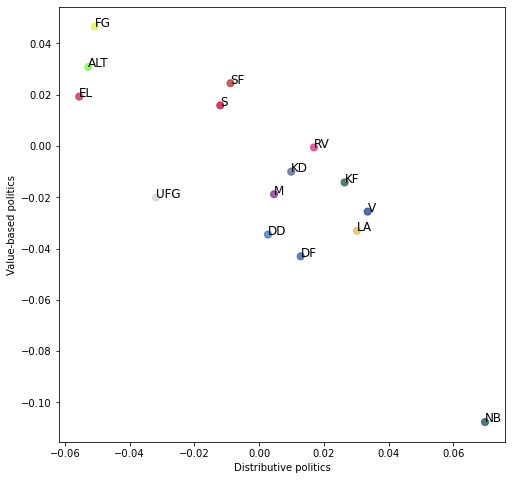

In [1304]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

# Assume you have a matrix of politician embeddings in the populism subspace,
# where each row represents an embedding and each column represents a subdimension.
embeddings = projected_matrix

# Initialize the plot and set the axis labels
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111) #, projection='3d'
ax.set_xlabel('Distributive politics')
ax.set_ylabel('Value-based politics')
#ax.set_zlabel('Moralised politics')

# Set the range of the axis
# ax.set_xlim([0.02, 0.125])
# ax.set_ylim([-0.01, 0.2])
# ax.set_zlim([0, 0.075])

# Create a scatter plot of the politician embeddings
xs = embeddings[:,0]
ys = embeddings[:,1]
#zs = embeddings[:,2]
ax.scatter(xs, ys, s=50, alpha=0.75, color=party_labels['color']) #, zs

for i, embedding in enumerate(embeddings):
    x, y = embedding #, z
    ax.text(x, y, party_labels.iloc[i]['party'], color='black', size=12) #, z

# Add selected word vectors and labels to the plot
# def plot_words(ax, dimension, projection_matrix, color, size=7):

#     for i, dimvec in enumerate(dimension.vecs['present']):
#         x, y, z = projection_matrix.T.dot(dimvec)
#         ax.scatter(x, y, z, s=0, alpha=1, color=color)
#         ax.text(x, y, z, dimension.words['present'][i], color=color, size=size)

#     for i, dimvec in enumerate(dimension.vecs['absent']):
#         x, y, z = projection_matrix.T.dot(dimvec)
#         ax.scatter(x, y, z, s=0.25, alpha=1, color=color)
#         ax.text(x, y, z, dimension.words['absent'][i], color=color, size=size)

# plot_words(ax, PC_dimension, projection_matrix, 'red')
# plot_words(ax, AP_dimension, projection_matrix, 'blue')
# plot_words(ax, MP_dimension, projection_matrix, 'green')

# Show the plot
plt.show()

<img src="ideological_compass.jpeg"  width="600">

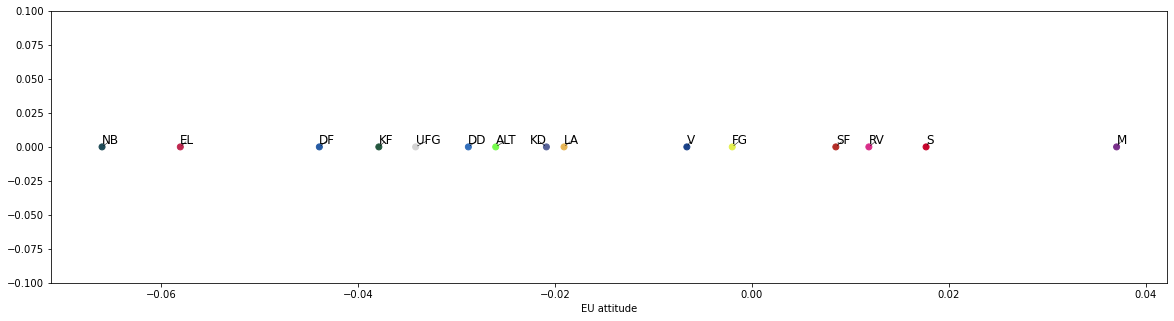

In [109]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
colorlist = combined_hover.dropna()['color']

# project politicians onto each subdimension
proj_dim = np.dot(pol2vec_model.party_vectors, eu_axis)

# create 3x1 subplot
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# plot projection onto first subdimension
ax.scatter(proj_dim, np.zeros_like(proj_dim), c=party_labels['color'])
ax.set_xlabel('EU attitude')
ax.set_ylim(-0.1, 0.1)

# add party labels to each of the subplots without adjusting text positions
for i, party in enumerate(party_labels['party']):
    ax.text(proj_dim[i], 0, party, color='black', size=12)

# adjust text positions to avoid overlapping
adjust_text([ax.texts[i] for i in range(len(ax.texts))], ax=ax, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# plot projection onto third subdimension
# axs[2].scatter(proj_dim3, np.zeros_like(proj_dim3), c=party_labels['color'])
# axs[2].set_xlabel('Moralised politics')
# axs[2].set_ylim(-0.1, 0.1)

plt.show()

In [56]:
parties = ['S', 'RV', 'KF', 'SF', 'DF', 'V', 'EL', 'LA', 'ALT']
gns = [8.1, 8.2, 7.3, 5.9, 2.4, 7.8, 3.5, 6.2, 5.5]

df_test = pd.DataFrame(zip(parties, gns), columns=['party', 'eu_avg'])

In [58]:
# map colors to party names:
color_map = dict(zip(party_labels['party'], party_labels['color']))

# create a list of colors for each party
colors = [color_map[party] for party in df_test['party']]
df_test['color'] = colors

In [59]:
df_test

,party,eu_avg,color
0,S,8.1,#C8042C
1,RV,8.2,#D82E8A
2,KF,7.3,#24573E
3,SF,5.9,#B42D27
4,DF,2.4,#265BA4
5,V,7.8,#1A4289
6,EL,3.5,#BF2850
7,LA,6.2,#E7B657
8,ALT,5.5,#75FB4C


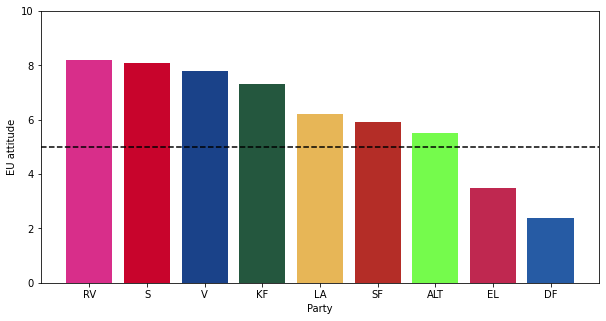

In [74]:
# sort bars by size:
df_test = df_test.sort_values(by='eu_avg', ascending=False)

# plot df_test as barchart:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_test['party'], df_test['eu_avg'], color=df_test['color'])
ax.set_xlabel('Party')
ax.set_ylabel('EU attitude')
ax.set_ylim(0, 10)

# draw hline at 5:
ax.axhline(5, color='black', linestyle='--')
